# Exercise 07.03

## Problem:

**[Purpose: Using a multimodal prior with the Metropolis algorithm, and seeing how chains can transition across modes or get stuck within them.]**

In this exercise, you will see that the Metropolis algorithm operates with multimodal distributions.

(A) Consider a prior distribution on coin bias that puts most credibility at 0.0, 0.5, and 1.0, which we will formulate as $p(θ) = (\cos(4πθ) + 1)^{2}/1.5$.

(B) Make a plot of the prior. _Hint_: `theta = seq(0,1,length=501); plot (theta , (cos(4*pi*theta)+1) ˆ 2/1.5 )`

(C) In the script BernMetrop.R, find the function definition that specifies the prior distribution. Inside that function definition, comment out the line that assigns a beta density to pTheta, and instead put in a trimodal prior like this:

    #pTheta = dbeta( theta , 1 , 1 )
    pTheta = (cos(4*pi*theta)+1)ˆ2/1.5

To have the Metropolis algorithm explore the prior, we give it empty data. Find the line in the script that specifies the data and set myData = c(). Run the script, using a proposal SD=0.2. Include the graphical output in your write-up. Does the histogram of the trajectory look like the graph of the previous part of the exercise?

(D) Repeat the previous part but now with myData = c(0,1,1). Include the graphical output in your write-up. Does the posterior distribution make sense? Explain why.

(E) Repeat the previous part but now with proposal SD=0.02. Include the graphical output in your write-up. Does the posterior distribution make sense? Explain why not; what has gone wrong? If we did not know from the previous part that this output was unrepresentative of the true posterior, how could we try to check? Hint: See next part.

(F) Repeat the previous part but now with the initial position at 0.99: trajectory[1] = 0.99. In conjunction with the previous part, what does this result tell us?

## Solution:

First, source the utilities:

In [1]:
source("../DBDA2Eprograms/DBDA2E-utilities.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



Loading required package: coda
Linked to JAGS 4.1.0
Loaded modules: basemod,bugs


#### A.

We will use a prior that puts the most credibility on 0.0, 0.5, and 1.0:

\begin{equation*}
p(\theta) = \frac{(\cos(4\pi\theta) + 1)^{2}}{4}
\end{equation*}

I opted for 4 instead of 1.5 as the normalization constant in order to bound the prior probability between 0 and 1.

#### B.

The following is a plot of the prior:

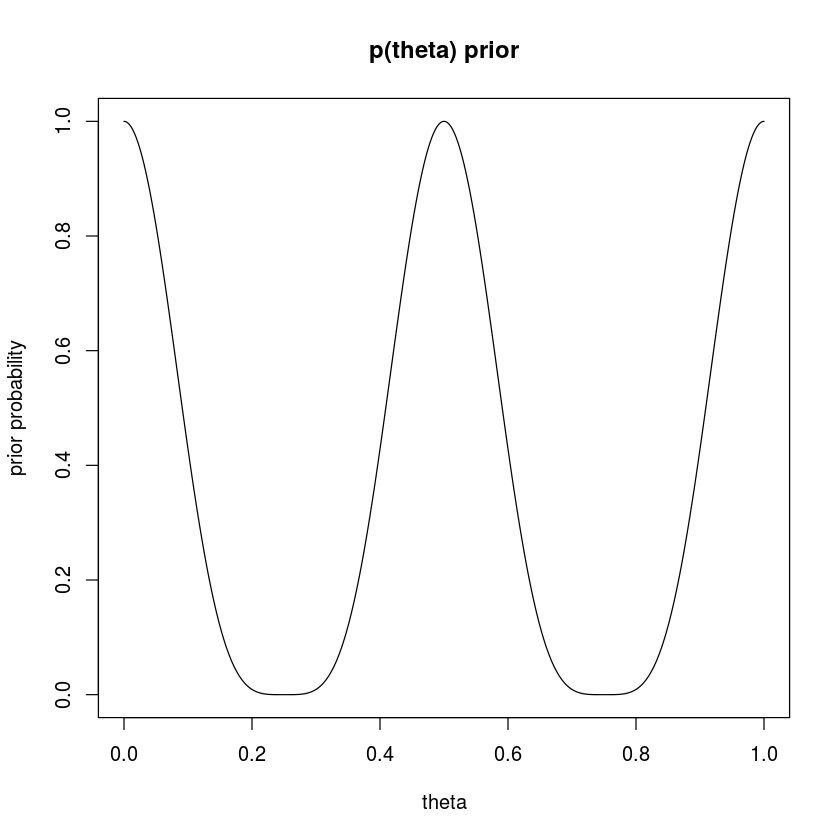

In [17]:
# create theta grid
theta = seq(0, 1, length = 1001)

# calculate prior across theta values
prior = ((cos(4*pi*theta) + 1)^2)/4

plot(theta, prior, type = "l",
     main = "p(theta) prior", xlab = "theta", ylab = "prior probability")

#### C.

This is the code in `BernMetrop.R` that denotes the prior probability:

In [18]:
prior = function( theta ) {
  #pTheta = dbeta( theta , 1 , 1 )
  pTheta = ((cos(4*pi*theta) + 1)^2)/4 # changed to the current prior
  # The theta values passed into this function are generated at random,
  # and therefore might be inadvertently greater than 1 or less than 0.
  # The prior for theta > 1 or for theta < 0 is zero:
  pTheta[ theta > 1 | theta < 0 ] = 0
  return( pTheta )
}

Initialize the scripts for the likelihood and relative probability of the posterior:

In [19]:
# The argument theta could be a vector, not just a scalar.
likelihood = function( theta , data ) {
  z = sum( data )
  N = length( data )
  pDataGivenTheta = theta^z * (1-theta)^(N-z)
  # The theta values passed into this function are generated at random,
  # and therefore might be inadvertently greater than 1 or less than 0.
  # The likelihood for theta > 1 or for theta < 0 is zero:
  pDataGivenTheta[ theta > 1 | theta < 0 ] = 0
  return( pDataGivenTheta )
}

# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
targetRelProb = function( theta , data ) {
  targetRelProb =  likelihood( theta , data ) * prior( theta )
  return( targetRelProb )
}

Initialize empty data in order to examine the prior:

In [20]:
# Specify the data, to be used in the likelihood function.
myData = c()

The following sets values for the Metropolis-Hastings algorithm:

In [21]:
# Specify the length of the trajectory, i.e., the number of jumps to try:
trajLength = 50000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = rep( 0 , trajLength )
# Specify where to start the trajectory:
trajectory[1] = 0.01 # arbitrary value
# Specify the burn-in period:
burnIn = ceiling( 0.0 * trajLength ) # arbitrary number, less than trajLength
# Initialize accepted, rejected counters, just to monitor performance:
nAccepted = 0
nRejected = 0

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 0.2:

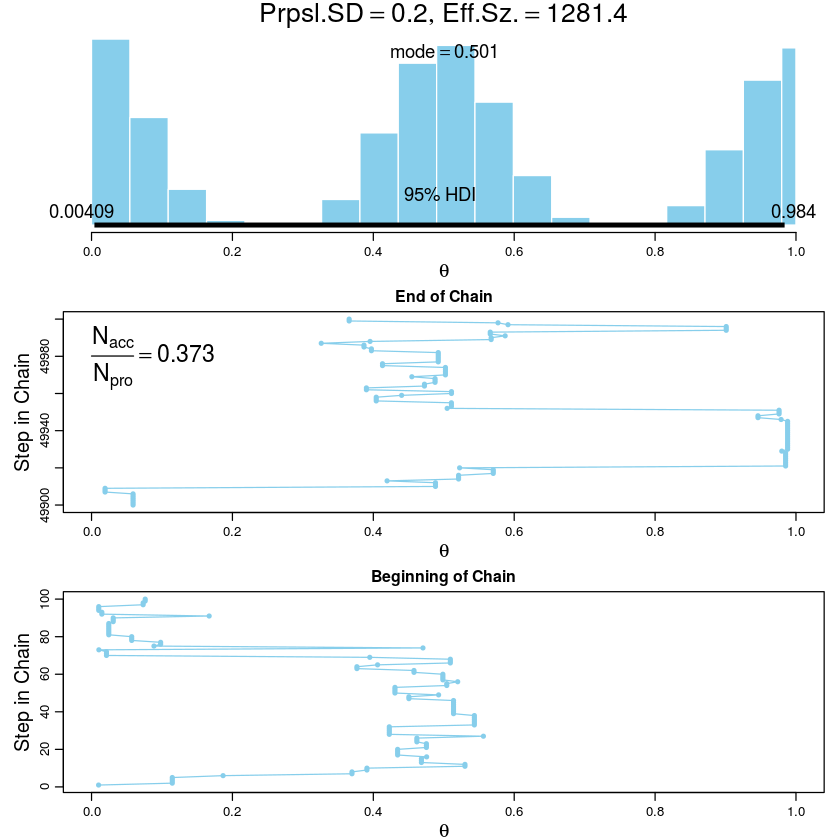

In [22]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[2]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

The histogram of the posterior seems to put emphasis on 0, 1, and 0.5. The HDI stretches from 0.00409 to 0.984, which covers the 0 and 1 bounds defined in the prior. The mode is at roughly 0.5. This matches our prior.

#### D.

Change the observed data to:

In [23]:
# Specify the data, to be used in the likelihood function.
myData = c(0, 1, 1)

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 0.2:

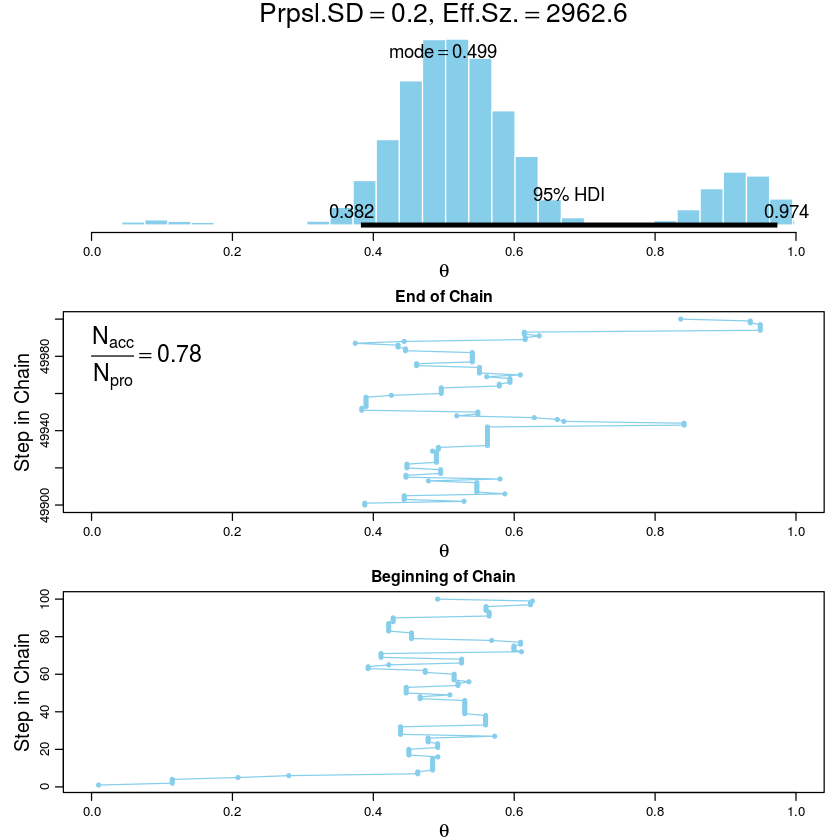

In [24]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[2]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

This does make sense. The results had two 1's and one 0, meaning that the posterior will place less emphasis on 0.

#### E.

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 0.02:

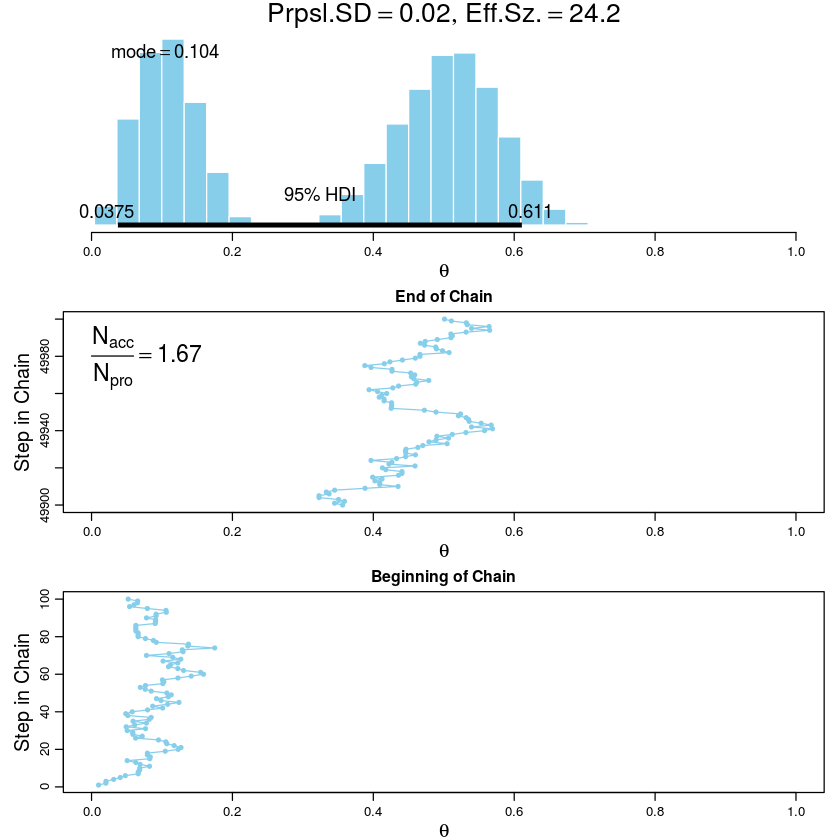

In [25]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[1]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

The results don't make much sense because we see a lot more 1's than 0's in the observed data. Therefore, the posterior distribution should place very little emphasis on 0. The reason why we see this particular posterior distribution is because the step size for the random walk is small, so the Metropolis-Hastings algorithm has trouble pushing past local minimums. If we set the number of iterations to be at least 10 times bigger, we may see the correct distribution in the posterior.

#### F.

The following sets values for the Metropolis-Hastings algorithm:

In [32]:
# Specify the length of the trajectory, i.e., the number of jumps to try:
trajLength = 50000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = rep( 0 , trajLength )
# Specify where to start the trajectory:
trajectory[1] = 0.99 # arbitrary value
# Specify the burn-in period:
burnIn = ceiling( 0.0 * trajLength ) # arbitrary number, less than trajLength
# Initialize accepted, rejected counters, just to monitor performance:
nAccepted = 0
nRejected = 0

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 0.02:

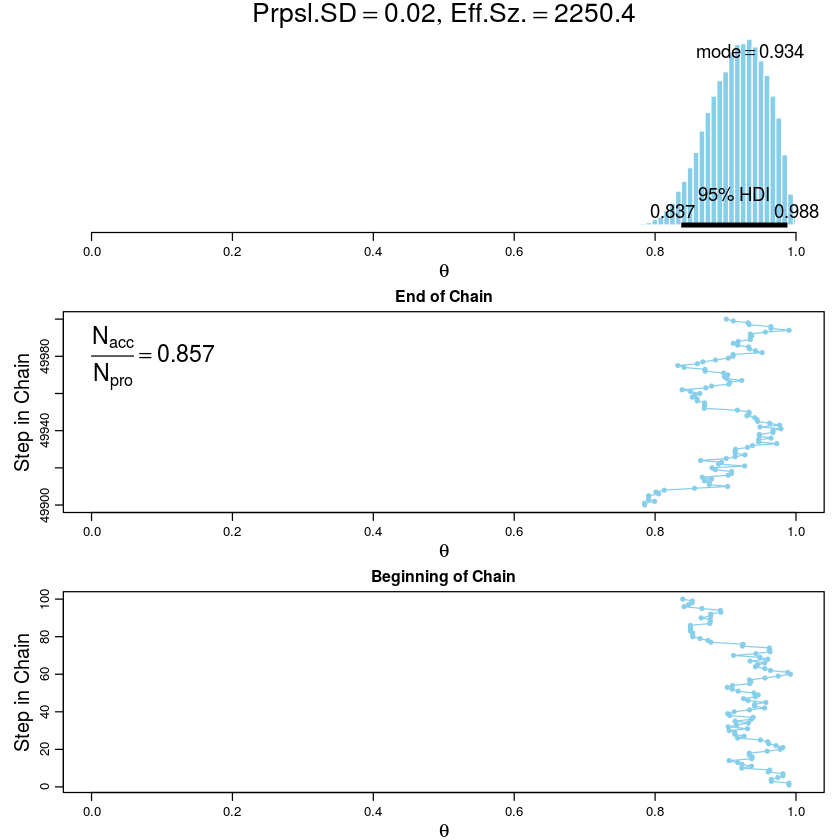

In [33]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[1]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

The results make more sense than the previous exercise (**E.**). Emphasis is now placed around $\theta = 1$, where the majority of the observations are. This occured because the trajectory now starts at $\theta = 0.99$. Since it is hard for the Metropolis-Hastings algorithm to escape local minimums with a proposal standard deviation of 0.02, it estimates a lot of the posterior weight as being near the initial trajectory value. Of course, this matches our data, but it is artificially driven by our choice of trajectory.